<a href="https://colab.research.google.com/github/areumham/tiny_python_projects/blob/master/deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import zeros,ones
from numpy.random import randn, randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Conv2DTranspose,LeakyReLU
from keras.layers import BatchNormalization,Dropout,Reshape,Flatten

In [ ]:
# Kaggle에서 이미지 디렉토리 정의
dataset_dir = "/content/drive/MyDrive/image_sample2/S001/L1"
# 디렉토리에 있는 이미지 경로 가져오기
image_paths = glob.glob(os.path.join(dataset_dir, "*/*.jpg"))

# 처음 65개 이미지만 고려
image_paths = image_paths[:65]

# 이미지를 열고 자르고, 크기를 조정하는 함수 생성
def load_and_preprocess_real_images(image_path, target_size=(64, 64)):
    # 이미지 열기
    img = Image.open(image_path)
    # 위와 아래에서 20픽셀을 잘라내어 정사각형으로 만듬
    img = img.crop((0, 20, 178, 198))
    # 이미지 크기 조정
    img = img.resize(target_size)
    # 이미지를 numpy array로 변환
    image = np.array(img) / 127.5 - 1
    return image
# 모든 이미지를 열고, 자르고, 크기를 조정
dataset = np.array([load_and_preprocess_real_images(img_path) for img_path in image_paths])

# 데이터셋 형태 출력
print(dataset.shape)



(60, 64, 64, 3)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


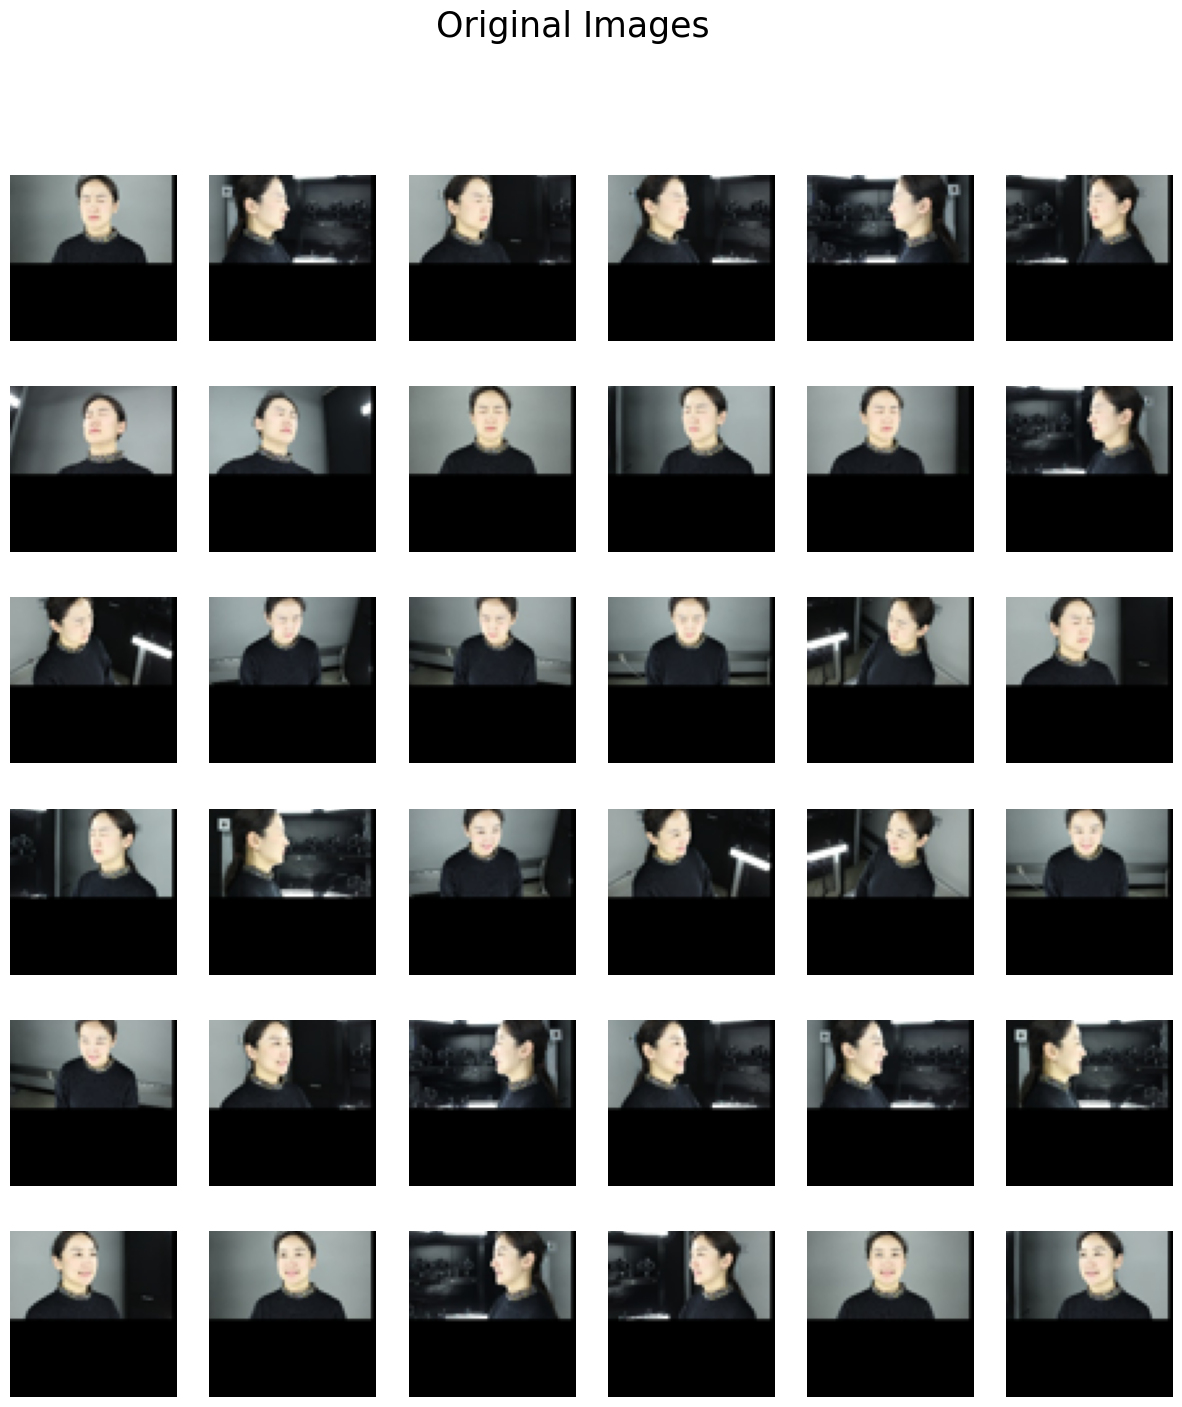

In [ ]:
# 처음 25개 이미지에 대한 서브 플롯 생성
flg, axes = plt.subplots(6, 6, figsize=(15, 16)) # plt는 그래프 그릴 떄 쓰임.

for i, ax in enumerate(axes.flat):
    # i 번째 이미지 가져오기
    img = dataset[i]
    # 플로팅을 위해 이미지를 [0,1] 범위로 재조정
    img_rescaled = (img+1)/2
    # i번째 서브플롯에 이미지 표시
    ax.imshow(img_rescaled)
    ax.axis("off")

# 상위 제목 추가
flg.suptitle("Original Images", fontsize=25)
plt.show()

In [ ]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, LeakyReLU, Flatten, Dropout

def build_discriminator(image_shape=(64, 64, 3)):
    model = Sequential()

    # 초기 컨볼루션 레이어 => 이미지를 다루는 딥러닝에서 핵심적인 요소
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same", input_shape=image_shape)) #  출력 텐서의 크기가 입력 텐서의 크기와 동일하게 유지되도록 함.
    model.add(LeakyReLU(alpha=0.2))

    # 두 번째 컨볼루션 레이어
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    # 세 번째 컨볼루션 레이어
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    # 네 번째 컨볼루션 레이어
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    # 다섯 번째 컨볼루션 레이어
    model.add(Conv2D(512, (3, 3), strides = (2, 2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    # 분류를 위한 평탄화 및 밀집 레이어
    model.add(Flatten())
    model.add(Dropout(0.4))  # 수정: 콤마 대신 점 사용
    model.add(Dense(1, activation="sigmoid"))

    # 옵티마이저 정의 및 모델 컴파일
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)  # 수정: 백틱 대신 등호 사용
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    # binary_crossentropy 분류 손실함수 중 하나로 이진 분류 모델에 사용
    return model

# 판별자 요약 구축 및 표시
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 256)         590080    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 256)        

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, LeakyReLU

def build_generator(latent_dim, channels=3):
    model = Sequential()

    # 초기 밀집 레이어
    model.add(Dense(16 * 16 * 128, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))

    # 컨볼루션 레이어를 위해 (16,16,128) 텐서로 변환
    model.add(Reshape((16, 16, 128)))

    # 첫 번째 디컨볼루션 레이어
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")) # 첫번째 인자는 이 레이어를 통과한 후 생성되는 특정 맵의 수, 두번째 인자는 필터의 크기
    model.add(LeakyReLU(0.2))

    # 두 번째 디컨볼루션 레이어
    model.add(Conv2DTranspose(128, (4, 4), strides=(1, 1), padding="same"))
    model.add(LeakyReLU(0.2))

    # 세 번째 디컨볼루션 레이어
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(0.2))

    # 네 번째 디컨볼루션 레이어
    model.add(Conv2DTranspose(64, (4, 4), strides=(1, 1), padding="same"))
    model.add(LeakyReLU(0.2))

    # tanh 활성화 함수를 사용하는 출력 컨볼루션 레이어
    model.add(Conv2D(channels, (8, 8), activation="tanh", padding="same")) # channels: 이 컨볼루션 레이어의 출력 채널 수, 두번째: 커널의 크기

    return model

# 생성자를 빌드하고 요약을 출력
generator = build_generator(100)
# 100차원의 노이즈 벡터를 입력으로 받아 이미지를 생성하는 생성자 모델 구축
# 생성된 이미지의 수는 출력층 구조와 노이즈 벡터를 입력으로 모델을 제공하는 횟수에 따라 결정
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       262272    
 Transpose)                                             

In [ ]:
def build_gen(generator,discriminator):

  # 디스크리미네이터를 학습 불가능하게 설정하여, GAN을 학습할 때 디스크리미네이터의 가중치가 업데이트 되지 않도록 한다.
  discriminator.trainable = False
  # GAN 모델 설정
  model = Sequential()
  #제네레이터 추가
  model.add(generator)

  #디스크리미네이터 추가
  model.add(discriminator)

  #GAN 모델 컴파일
  # adam 인자
  # learning_rate: 학습률은 모델이 가중치를 업데이트할 때 사용하는 스텝 크기를 결정 => 값이 너무 크면 불안정, 값이 너무 작으면 학습이 느려짐
  # beta_1:beta_1: Adam 옵티마이저에서 1차 모멘트(평균)를 계산할 때 사용하는 지수 감소율이다.
  # 일반적으로 beta_1은 0.9로 설정되지만, 여기서는 0.5로 설정되어 있다. 이는 GAN 학습에서 더 안정적인 훈련을 돕기 위한 설정다.
  optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return model

In [ ]:
# 데이터셋에서 무작위로 실제 이미지를 선택하고, 이를 1로 라벨링하여 실제 이미지임을 나타냄.
def generate_real_samples(dataset, num_samples):
    # 0 무작위로 선택한 값의 시작 범위 지정 0부터 시작
    # dataset.shape[0]: 무작위로 선택할 값의 범위의 끝을 지정: 데이터 셋의 총 샘플 수 : 1000개의 샘플이 있다면 1000개가 됨.
    # num_samples: 선택할 무작위 샘플의 개수

    sample_indices = randint(0, dataset.shape[0], num_samples)
    x = dataset[sample_indices]

    # 생성할 배열의 형태를 지정: 여기서는 num_samples 개수만큼의 샘플을 갖는 배열을 생성하며, 각 샘플은 1차원이고, 크기는 1임.
    # 배열의 메모리 배치 순서 지정:'ones' 함수는 기본적으로 배열을 생성할 때 C스타일의 메모리 배치 순서를 사용
    y = np.ones((num_samples, 1))  # num_samples 개수만큼의 1로 이루어진 배열을 생성. 이 배열은 실제 샘플이나 생성된 샘플이 '진짜'임을 나타내는 라벨로 사용될 수 있습니다.
    return x, y

In [ ]:
#`generate_noise_samples` - 무작위 노이즈 벡터(관용적으로 변수 Z 에 생성, 저장하여 활용하는데
#이는 단순하게 균등분포(Uniform Distribution)이나 정규분포(Normal Distribution)에서 무작위로 추출된 값)를 생성합니다.
# 이 벡터들은 Generator가 가짜 이미지를 생성하는 데 사용됩니다.
def generate_noise_samples(num_samples, noise_dim):
  X_noise = randn(noise_dim*num_samples) # 평균이 0이고 표준편차가 1인 랜덤 숫자를 생성.
  X_noise = X_noise.reshape(num_samples, noise_dim) # 생성한 랜덤 숫자를 (num_samples, noise_dim) 형태의 2차원 배열로 변환.
  return X_noise


In [ ]:
def generate_fake_samples(generator, noise_dim, num_samples):
  X_noise = generator.generate_noise_samples(num_samples, noise_dim) # generator 객체의 generate_noise_samples 메서드를 호출하여 num_samples와 noise_dim을 전달하고, 그 결과로 생성된 노이즈 샘플을 X_noise에 저장
  x = generator.predict(X_noise) # predict 메소드를 사용해 X_noise를 입력으로 받아 가짜 샘플을 생성
  y = zeros((num_samples, 1)) # 모든 샘플에 대해 '가짜'임을 나타내는 0으로 채워진 레이블 배열 생성
  return x, y


In [ ]:
def generate_images(epoch, generator, num_samples, noise_dim=100):
    """
    주어진 에포크에 대해 생성기 모델로부터 이미지 생성
    """
    # 노이즈 샘플 생성
    X_noise = generate_noise_samples(num_samples, noise_dim)

    # 생성기를 사용하여 노이즈로부터 이미지 생성
    x = generator.predict(X_noise, verbose=0)  # 생성기가 X_noise를 입력으로 받아 이미지를 생성. verbose=0은 과정을 조용히 처리함을 의미함.

    # 시각화를 위해 이미지를 [0, 1]로 재조정
    x = (x + 1) / 2

    return x

In [ ]:
def plot_generated_images(epoch, generator, num_samples = 6, noise_dim=100,figsize=(15,3)):
  """
  주어진 에포크에 대해 생성기 모델로부터 생성된 이미지를 시각화하고 플로팅 함.
  """

  # 노이즈 샘플 생성
  X_noise = generate_noise_samples(num_samples, noise_dim)

  # 생성기를 사용하여 노이즈로부터 이미지 생성
  x = generator.predict(X_noise, verbose=0)  # 생성기가 X_noise를 입력으로 받아 이미지를 생성. verbose=0은 과정을 조용히 처리함을 의미함.

  # 시각화를 위해 이미지를 [0,1]로 재조정
  X = (X+1) / 2

  # 1행 num_samples 열의 서브플롯을 생성하고 크기는 figsize로 설정
  fig, axes = plt.subplots(1, num_samples, figsize=figsize)

  # num_samples만큼 반복하면서 이미지를 서브플롯에 추가
  for i in range(num_samples):
    axes[i].imshow(X[i])  # 서브플롯 axes[i]에 이미지 X[i]를 추가
    axes[i].axis('off')  # 축을 끔
  # 서브플롯:  하나의 그래픽 창(figure) 안에 여러 개의 작은 그래프나 이미지를 배열 형식으로 나란히 표시할 수 있게 해주는 기능
  # 설명적인 제목 추가
  fig.suptitle(f"Generated Images at Epoch {epoch+1}", fontsize=22)  # 생성된 이미지 위에 에포크 번호(현재 학습이 진행된 횟수)를 포함한 설명적인 제목을 추가
  plt.tight_layout()  # 레이아웃을 깔끔하게 정리
  plt.show()  # 그래프를 화면에 표시

In [ ]:
import numpy as np

def train(generator_model, discriminator_model, gan_model, dataset, noise_dimension,
          num_epochs=100, batch_size=128, display_frequency=10, verbose=1):
    # 각 에포크 마다 생성된 이미지를 저장할 빈 리스트를 만듬.
    saved_images_for_epochs = []

    # 에포크당 배치 수를 계산
    batches_per_epoch = int(dataset.shape[0] / batch_size)

    # 배치 크기의 절반을 계산
    half_batch_size = int(batch_size / 2)

    # 에포크 반복
    for epoch in range(num_epochs):
        # 이 에포크 내의 모든 배치를 반복함.
        for batch in range(batches_per_epoch):
            # 실제 이미지를 생성, 해당 레이블 생성
            real_images, real_labels = generate_real_samples(dataset, half_batch_size)

            # 실제 이미지로 디스크리미네이터를 훈련시키고 손실과 정확도 계산
            dsr_loss_real, dsr_acc_real = discriminator_model.train_on_batch(real_images, real_labels)

            # 가짜 이미지를 생성하고 해당 레이블 생성
            fake_images, fake_labels = generate_fake_samples(generator_model, noise_dimension, half_batch_size)

            # 가짜 이미지로 디스크리미네이터를 훈련시키고 손실과 정확도 계산
            dsr_loss_fake, dsr_acc_fake = discriminator_model.train_on_batch(fake_images, fake_labels)

            # 실제 이미지와 가짜 이미지에 대한 디스크리미네이터의 평균 손실과 정확도 계산
            dsr_loss = 0.5 * np.add(dsr_loss_real, dsr_loss_fake)
            dsr_acc = 0.5 * np.add(dsr_acc_real, dsr_acc_fake)

            # 생성기를 훈련시키기 위해 노이즈 샘플과 해당 레이블을 생성
            gen_noise = generate_noise_samples(batch_size, noise_dimension)
            gan_labels = np.ones((batch_size, 1))

            # 생성기를 훈련시키고 손실과 정확도 계산
            gan_loss = gan_model.train_on_batch(gen_noise, gan_labels)

            if verbose:  # 이 조건은 verbose가 0이 아닌지 확인
                # 이 배치에 대한 훈련 정보를 출력
                print(f"[ Epoch: {epoch+1} , Batch: {batch+1} ] --> [ Discriminator Loss: {dsr_loss:.6f} , Discriminator Accuracy: {100*dsr_acc:.2f}% ] [ Generator Loss: {gan_loss:.6f} ]")

        # 지정된 빈도로 생성된 이미지를 표시
        if epoch % display_frequency == 0:
            generated_images_for_epoch = generate_images(epoch, generator_model)
            saved_images_for_epochs.append(generated_images_for_epoch)

            # 생성기의 진행 상황을 시각화하기 위해 생성된 이미지를 플로팅
            plot_generated_images(epoch, generator_model)

    # Kaggle 출력 파일 크기 제한으로 인해, 모델 저장은 주석 처리.
    # generator_model.save('Photorealistic_Face_Generator.h5')

    return saved_images_for_epochs



In [ ]:
import numpy as np
from keras.models import Model, Sequential
from keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, Flatten, Input
from keras.optimizers import Adam
from keras.initializers import RandomNormal

def build_generator(latent_dim, channels=3):
    model = Sequential()
    model.add(Dense(16 * 16 * 128, input_dim=latent_dim))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((16, 16, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(1, 1), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2DTranspose(64, (4, 4), strides=(1, 1), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(channels, (3, 3), activation="tanh", padding="same"))
    return model

def build_discriminator(input_shape=(64, 64, 3)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same", input_shape=input_shape))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    z = Input(shape=(generator.input_shape[1],))
    img = generator(z)
    valid = discriminator(img)
    model = Model(z, valid)
    return model

def generate_real_samples(dataset, num_samples):
    sample_indices = np.random.randint(0, dataset.shape[0], num_samples)
    x = dataset[sample_indices]
    y = np.ones((num_samples, 1))
    return x, y

def generate_fake_samples(generator, latent_dim, num_samples):
    z = np.random.randn(num_samples, latent_dim)
    images = generator.predict(z)
    y = np.zeros((num_samples, 1))
    return images, y

def generate_noise_samples(batch_size, latent_dim):
    return np.random.randn(batch_size, latent_dim)

def train(generator_model, discriminator_model, gan_model, dataset, noise_dimension,
          num_epochs=100, batch_size=128, display_frequency=10, verbose=1):
    saved_images_for_epochs = []
    batches_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch_size = int(batch_size / 2)

    for epoch in range(num_epochs):
        for batch in range(batches_per_epoch):
            real_images, real_labels = generate_real_samples(dataset, half_batch_size)
            dsr_loss_real, dsr_acc_real = discriminator_model.train_on_batch(real_images, real_labels)

            fake_images, fake_labels = generate_fake_samples(generator_model, noise_dimension, half_batch_size)
            dsr_loss_fake, dsr_acc_fake = discriminator_model.train_on_batch(fake_images, fake_labels)

            dsr_loss = 0.5 * np.add(dsr_loss_real, dsr_loss_fake)
            dsr_acc = 0.5 * np.add(dsr_acc_real, dsr_acc_fake)

            gen_noise = generate_noise_samples(batch_size, noise_dimension)
            gan_labels = np.ones((batch_size, 1))
            gan_loss = gan_model.train_on_batch(gen_noise, gan_labels)

            if verbose:
                print(f"[Epoch: {epoch+1}, Batch: {batch+1}] --> [Discriminator Loss: {dsr_loss:.6f}, Discriminator Accuracy: {100*dsr_acc:.2f}%] [Generator Loss: {gan_loss:.6f}]")

        if epoch % display_frequency == 0:
            saved_images_for_epochs.append(generator_model.predict(generate_noise_samples(25, noise_dimension)))

    return saved_images_for_epochs

# 생성기 입력을 위한 노이즈 차원 설정
noise_dimension = 100

# 생성기 모델 생성
generator_model = build_generator(noise_dimension)

# 판별기 모델 생성
discriminator_model = build_discriminator()

# 판별기 모델 컴파일
discriminator_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# GAN 모델 생성
gan_model = build_gan(generator_model, discriminator_model)

# GAN 모델 컴파일
gan_model.compile(optimizer=Adam(), loss='binary_crossentropy')

# 데이터셋 생성
dataset = np.random.rand(1000, 64, 64, 3)

# 데이터셋에서 GAN 모델을 학습시키고 저장된 이미지 리스트를 얻음.
saved_images = train(generator_model, discriminator_model, gan_model, dataset, noise_dimension, num_epochs=251, batch_size=128, display_frequency=50, verbose=1)

# 출력 예시
print("Training completed. Saved images per epoch: ", len(saved_images))


2/2 [==============================] - 5s 2s/step
[Epoch: 1, Batch: 1] --> [Discriminator Loss: 0.707993, Discriminator Accuracy: 3.91%] [Generator Loss: 0.691359]
2/2 [==============================] - 2s 1s/step
[Epoch: 1, Batch: 2] --> [Discriminator Loss: 0.569932, Discriminator Accuracy: 50.00%] [Generator Loss: 0.609677]
2/2 [==============================] - 2s 989ms/step
[Epoch: 1, Batch: 3] --> [Discriminator Loss: 0.816005, Discriminator Accuracy: 50.00%] [Generator Loss: 0.314501]
2/2 [==============================] - 3s 1s/step
[Epoch: 1, Batch: 4] --> [Discriminator Loss: 1.408934, Discriminator Accuracy: 50.00%] [Generator Loss: 0.199711]
2/2 [==============================] - 2s 984ms/step
[Epoch: 1, Batch: 5] --> [Discriminator Loss: 1.042534, Discriminator Accuracy: 50.00%] [Generator Loss: 0.444240]
2/2 [==============================] - 3s 2s/step
[Epoch: 1, Batch: 6] --> [Discriminator Loss: 0.633991, Discriminator Accuracy: 50.00%] [Generator Loss: 1.004349]
2/2 [

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(64 * 64 * 3, activation='tanh'))
    model.add(Reshape((64, 64, 3)))
    return model

def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(64, 64, 3)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

def save_plot(examples, epoch, n=5):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i])
    filename = f'generated_plot_epoch{epoch + 1}.png'
    plt.savefig(filename)
    plt.close()

def train(generator_model, discriminator_model, gan_model, dataset, latent_dim, num_epochs=100, batch_size=128, display_frequency=50, verbose=1):
    saved_images = []
    for epoch in range(num_epochs):
        for batch in range(len(dataset) // batch_size):
            idx = np.random.randint(0, len(dataset), batch_size)
            real_images = dataset[idx]
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            fake_images = generator_model.predict(noise)

            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))
            d_loss_real = discriminator_model.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator_model.train_on_batch(fake_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            valid_y = np.ones((batch_size, 1))
            g_loss = gan_model.train_on_batch(noise, valid_y)

            if verbose:
                print(f"[Epoch: {epoch+1}, Batch: {batch+1}] --> [Discriminator Loss: {d_loss[0]:.6f}, Discriminator Accuracy: {d_loss[1]*100:.2f}%] [Generator Loss: {g_loss:.6f}]")

        if (epoch + 1) % display_frequency == 0:
            noise = np.random.normal(0, 1, (25, latent_dim))
            gen_images = generator_model.predict(noise)
            saved_images.append(gen_images)
            save_plot(gen_images, epoch)

    return saved_images

# 데이터셋 생성
dataset = np.random.rand(1000, 64, 64, 3)

# 모델 생성 및 컴파일
noise_dimension = 100
generator_model = build_generator(noise_dimension)
discriminator_model = build_discriminator()
discriminator_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
gan_model = build_gan(generator_model, discriminator_model)
gan_model.compile(optimizer=Adam(), loss='binary_crossentropy')

# 학습
saved_images = train(generator_model, discriminator_model, gan_model, dataset, noise_dimension, num_epochs=251, batch_size=128, display_frequency=50, verbose=1)

# 저장된 이미지 시각화
for i, images in enumerate(saved_images):
    save_plot(images, i*50)

print("Training completed. Saved images per epoch: ", len(saved_images))


##12시간 런타임 시간이 끝나 에러로 나온 겁니다! 코드 오류는 아닙니다.


4/4 [==============================] - 1s 75ms/step
[Epoch: 1, Batch: 1] --> [Discriminator Loss: 0.746142, Discriminator Accuracy: 37.11%] [Generator Loss: 1.231283]
4/4 [==============================] - 0s 26ms/step
[Epoch: 1, Batch: 2] --> [Discriminator Loss: 10.542497, Discriminator Accuracy: 50.00%] [Generator Loss: 0.000002]
4/4 [==============================] - 0s 56ms/step
[Epoch: 1, Batch: 3] --> [Discriminator Loss: 9.111225, Discriminator Accuracy: 50.00%] [Generator Loss: 0.036384]
4/4 [==============================] - 0s 29ms/step
[Epoch: 1, Batch: 4] --> [Discriminator Loss: 0.142515, Discriminator Accuracy: 94.53%] [Generator Loss: 19.264503]
4/4 [==============================] - 0s 25ms/step
[Epoch: 1, Batch: 5] --> [Discriminator Loss: 26.795532, Discriminator Accuracy: 40.62%] [Generator Loss: 0.412376]
4/4 [==============================] - 0s 26ms/step
[Epoch: 1, Batch: 6] --> [Discriminator Loss: 3.109260, Discriminator Accuracy: 44.92%] [Generator Loss: 0.003

KeyboardInterrupt: 

In [ ]:
import os

def save_plot(examples, epoch, n=5):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i])
    filename = f'generated_plot_epoch{epoch + 1}.png'
    plt.savefig(os.path.join('./', filename))
    plt.close()


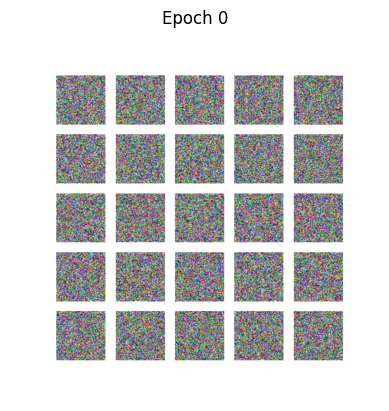

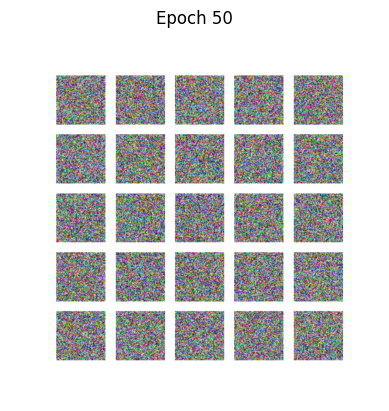

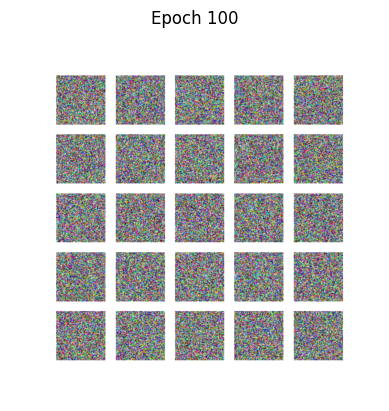

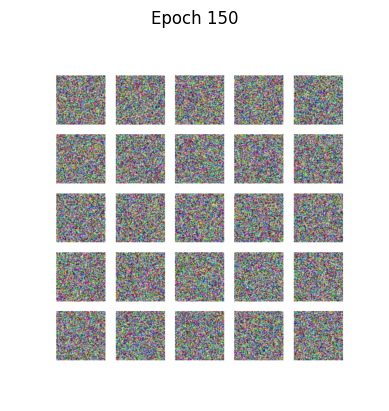

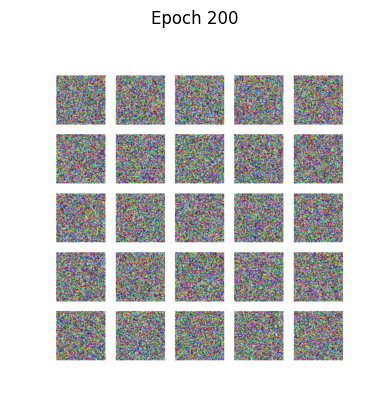

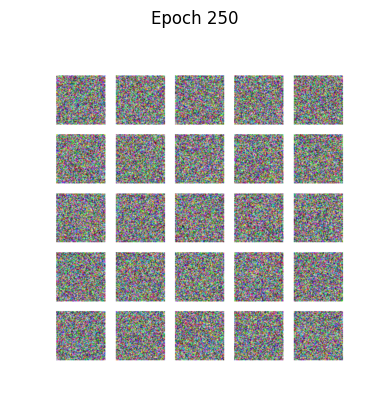

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

def save_plot(examples, epoch, n=5):
    examples = (examples + 1) / 2.0
    plt.figure(figsize=(10, 10))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i])
    filename = f'generated_plot_epoch{epoch}.png'
    plt.savefig(os.path.join('./', filename))
    plt.close()

# 임의의 예제 데이터 생성 (5x5 이미지, RGB 채널)
def generate_fake_images(num_images):
    return np.random.rand(num_images, 64, 64, 3) * 2 - 1

# 에포크마다 예제 이미지 저장
for epoch in range(0, 251, 50):
    examples = generate_fake_images(25)
    save_plot(examples, epoch)

# 저장된 이미지를 시각화
for epoch in range(0, 251, 50):
    filename = f'generated_plot_epoch{epoch}.png'
    filepath = os.path.join('./', filename)
    try:
        img = mpimg.imread(filepath)
        plt.figure()
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Epoch {epoch}')
        plt.show()
    except FileNotFoundError:
        print(f"File not found: {filepath}")
